In [1]:
from ekonlpy.sentiment import MPCK
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

## 금융통화위원회 의사록 어조 분석
- 의사록 어조 측정
1. 문장 : 금리 사전을 기반으로 긍/부정 카운트 후, 문장의 어조 계산 (문장 tone = (Pos - Neg) / (Pos + Neg))
2. 문서 : 문장의 어조를 계산한 값으로 0보다 크면 "Hawkish", 작으면 "Dovish"로 나누어 다시 문서 전체의 어조 계산 (문서 tone = (Pos - Neg) / (Pos + Neg))

In [14]:
# 금리 상승/하락 사전
pos_dict = pd.read_csv("./data/pos_dict.csv")
neg_dict = pd.read_csv("./data/neg_dict.csv")
# 금융통화위원회 의사록
min_df = pd.read_csv("./data/minutes_contents.csv")
# 기준 금리
base_df = pd.read_csv("./data/BOK_base_rate.csv")

mpck = MPCK()

# 각 사전의 단어들을 리스트로 분류
pos_list = pos_dict["word"].to_list()
neg_list = neg_dict["word"].to_list()
min_df

,date,title,contents
0,2005-06-09,금융통화위원회 의사록(2005년도 제12차)(2005.6.9).txt,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...
1,2005-07-07,금융통화위원회 의사록(2005년도 제14차)(2005.7.7).txt,일부 위원은 6월 들어 국제유가가 크게 오르고 원화와 엔화간 동조화 현상이 뚜렷...
2,2005-08-11,금융통화위원회 의사록(2005년도 제17차)(2005.8.11).txt,일부 위원은 위안화 절상 이후 아시아 통화중 우리나라 원화의 절상폭이 가장 컸다...
3,2005-09-08,금융통화위원회 의사록(2005년도 제19차)(2005.9.8).txt,일부 위원은 최근 인도네시아 금융불안 사태가 발생한 가운데 국제 환투기세력이 인...
4,2005-10-11,금융통화위원회 의사록(2005년도 제21차)(2005.10.11).txt,일부 위원은 미국과 우리나라의 정책금 리 격차가 확대되고 있는 가운데 금년 두 차...
...,...,...,...
121,2016-02-16,금융통화위원회 의사록(2016년도 제3차)(2016.2.16).txt,일부 위원은 도이치은행의 최근 상황과 이 에 따른 시장의 영향에 대한 관련부서의 ...
122,2016-03-10,금융통화위원회 의사록(2016년도 제5차)(2016.3.10.).txt,일부 위원은 지난 5년간 미 달러화대비 주 요국 통화의 흐름을 살펴보면 원화가치의...
123,2016-04-19,금융통화위원회 의사록(2016년도 제7차)(2016.4.19.).txt,일부 위원은 최근 원화가치의 절상폭이 확 대되고 있는 가운데 미국 BHC(Benn...
124,2016-05-13,금융통화위원회 의사록(2016년도 제9차)(2016.5.13.).txt,일부 위원은 국내 통화정책 운영의 가장 중 - 7 - 요한 대외 리스크로 주...


#### 데이터 전처리 함수

In [15]:
# 토큰화 + n-gram화
def stc_ngram(sentence):
    tokens = mpck.tokenize(sentence)
    ngrams = mpck.ngramize(tokens)
    result = tokens + ngrams
    return result

# 문장 어조 계산 후 라벨링
def get_label(df) :
    if df["tone_doc"] > 0 :
        return "Hawkish"
    elif df["tone_doc"] < 0 :
        return "Dovish"

## 금리 사전을 기반으로 긍/부정 카운트 후, 문장의 어조 계산

In [16]:
# 문장 tone 카운트 컬럼 생성
min_df["pos_cnt"] = np.nan
min_df["neg_cnt"] = np.nan

for i in tqdm(range(len(min_df))) :
    # 문장 tone의 최종 카운트가 될 변수
    pos_count = 0
    neg_count = 0
    sentences = min_df["contents"][i].split("@@@")
    for sentence in sentences :
        # 문서 별 문장 tone 카운트 변수
        up_count = 0
        down_count = 0
        # tokenize + ngramize
        ngram_list = stc_ngram(sentence)
        for ngram in ngram_list :
            if ngram in pos_list : # 금리 상승 사전
                up_count += 1
            elif ngram in neg_list : # 금리 하락 사전
                down_count += 1
        try: # sentence_tone 어조 계산
            sentence_tone = (up_count - down_count) / (up_count + down_count)
        except ZeroDivisionError : # 연산 결과가 0
            sentence_tone = 0
        if sentence_tone > 0 :
            pos_count += 1 # 최종 pos 카운트
        elif sentence_tone < 0 :
            neg_count += 1 # 최종 neg 카운트
    # 최종 카운트를 DataFrame에 업데이트
    min_df.at[i, "pos_cnt"] = pos_count
    min_df.at[i, "neg_cnt"] = neg_count
min_df.head(5)

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:23<00:00,  1.14s/it]


,date,title,contents,pos_cnt,neg_cnt
0,2005-06-09,금융통화위원회 의사록(2005년도 제12차)(2005.6.9).txt,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,60.0,78.0
1,2005-07-07,금융통화위원회 의사록(2005년도 제14차)(2005.7.7).txt,일부 위원은 6월 들어 국제유가가 크게 오르고 원화와 엔화간 동조화 현상이 뚜렷...,56.0,76.0
2,2005-08-11,금융통화위원회 의사록(2005년도 제17차)(2005.8.11).txt,일부 위원은 위안화 절상 이후 아시아 통화중 우리나라 원화의 절상폭이 가장 컸다...,52.0,90.0
3,2005-09-08,금융통화위원회 의사록(2005년도 제19차)(2005.9.8).txt,일부 위원은 최근 인도네시아 금융불안 사태가 발생한 가운데 국제 환투기세력이 인...,54.0,75.0
4,2005-10-11,금융통화위원회 의사록(2005년도 제21차)(2005.10.11).txt,일부 위원은 미국과 우리나라의 정책금 리 격차가 확대되고 있는 가운데 금년 두 차...,50.0,85.0


In [17]:
# 문장의 어조를 계산하여 문서의 어조 라벨링 컬럼 생성
min_df["tone_doc"] = (min_df["pos_cnt"] - min_df["neg_cnt"]) / (min_df["pos_cnt"] + min_df["neg_cnt"])
min_df["tone_doc_label"] = min_df.apply(get_label, axis = 1)
min_df.head(5)

,date,title,contents,pos_cnt,neg_cnt,tone_doc,tone_doc_label
0,2005-06-09,금융통화위원회 의사록(2005년도 제12차)(2005.6.9).txt,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,60.0,78.0,-0.130435,Dovish
1,2005-07-07,금융통화위원회 의사록(2005년도 제14차)(2005.7.7).txt,일부 위원은 6월 들어 국제유가가 크게 오르고 원화와 엔화간 동조화 현상이 뚜렷...,56.0,76.0,-0.151515,Dovish
2,2005-08-11,금융통화위원회 의사록(2005년도 제17차)(2005.8.11).txt,일부 위원은 위안화 절상 이후 아시아 통화중 우리나라 원화의 절상폭이 가장 컸다...,52.0,90.0,-0.267606,Dovish
3,2005-09-08,금융통화위원회 의사록(2005년도 제19차)(2005.9.8).txt,일부 위원은 최근 인도네시아 금융불안 사태가 발생한 가운데 국제 환투기세력이 인...,54.0,75.0,-0.162791,Dovish
4,2005-10-11,금융통화위원회 의사록(2005년도 제21차)(2005.10.11).txt,일부 위원은 미국과 우리나라의 정책금 리 격차가 확대되고 있는 가운데 금년 두 차...,50.0,85.0,-0.259259,Dovish


In [18]:
# 문장, 문서의 어조 계산 결과 저장
min_df.to_csv("./data/minutes_tone_result.csv", encoding = "utf-8")

In [19]:
# 기준 금리 데이터 확인
base_df = pd.read_csv("./data/BOK_base_rate.csv")
base_df.head(5)

,date,rate
0,2008-02-29,5.0
1,2008-03-01,5.0
2,2008-03-02,5.0
3,2008-03-03,5.0
4,2008-03-04,5.0


In [20]:
# 의사록, 기준 금리 DataFrame 병합
b_m_df = pd.merge(min_df, base_df, on = "date", how = "inner")
b_m_df.head(5)

,date,title,contents,pos_cnt,neg_cnt,tone_doc,tone_doc_label,rate
0,2008-05-08,금융통화위원회 의사록(2008년도 제10차)(2008.5.8).txt,"일부 위원은 국제금융시장에서 신용위험,｢ ․ ｣ 이 완화되면 재정거래유인이 축소되어...",16.0,36.0,-0.384615,Dovish,5.00
1,2008-06-12,금융통화위원회 의사록(2008년도 제12차)(2008.6.12).txt,"일부 위원은,｢ ․ ｣ 최근 국내은행의 외화자금 사정이 개선되고는 있으나 일부 신용...",18.0,32.0,-0.280000,Dovish,5.00
2,2008-07-10,금융통화위원회 의사록(2008년도 제14차)(2008.7.10).txt,일부 위원은 최근 환율상승압력이 증대 된 데에는 경상수지 적자 및 외국인 주식매도...,58.0,63.0,-0.041322,Dovish,5.00
3,2008-08-07,금융통화위원회 의사록(2008년도 제16차)(2008.8.7).txt,"일부 위원은 최근 외환보유액 감소, ,｢ ․ ｣ 외국인 주식 채권투자자금 유출 국내...",15.0,37.0,-0.423077,Dovish,5.25
4,2008-09-11,금융통화위원회 의사록(2008년도 제18차)(2008.9.11).txt,"일부 위원은 우리나라 프리미엄, CDS｢ ․ ｣ 상승에 따른 재정거래유인 축소 연말...",15.0,46.0,-0.508197,Dovish,5.25


## 의사록 어조와 기준 금리의 상관계수 산출

In [27]:
corre = b_m_df[["rate", "tone_doc"]].corr()
corre

,rate,tone_doc
rate,1.000000,0.424954
tone_doc,0.424954,1.000000


## 상관관계 시각화 그래프

### 🌟일별 그래프

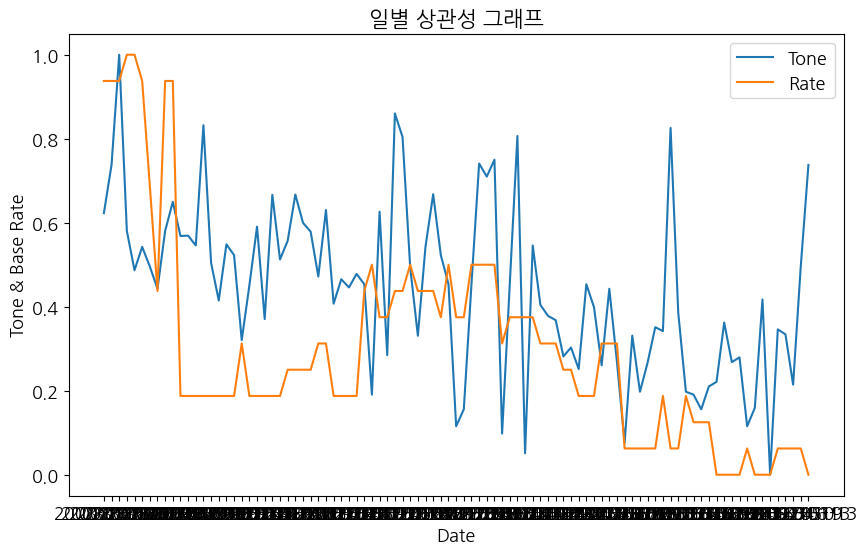

In [22]:
scaler = MinMaxScaler()

# x, y 넘파이 배열로 변환
x = np.array(b_m_df["date"])
y1 = np.array(b_m_df["tone_doc"]).reshape(-1, 1)
y2 = np.array(b_m_df["rate"]).reshape(-1, 1)

y1_scaled = scaler.fit_transform(y1)
y2_scaled = scaler.fit_transform(y2)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize=(10, 6))

plt.plot(x, y1_scaled, label="Tone")
plt.plot(x, y2_scaled, label="Rate")

plt.xlabel("Date")
plt.ylabel("Tone & Base Rate")
plt.title("일별 상관성 그래프")
plt.legend()

plt.show()

### 🌟연도별 그래프

In [23]:
# 연도별 그래프를 출력하기 위해 기존 DataFrame을 reindex하여 새 DataFrame 생성
graph_df = b_m_df.reindex(columns = ["date", "tone_doc", "rate"])
print(len(graph_df))
graph_df.head(5)

93


,date,tone_doc,rate
0,2008-05-08,-0.384615,5.00
1,2008-06-12,-0.280000,5.00
2,2008-07-10,-0.041322,5.00
3,2008-08-07,-0.423077,5.25
4,2008-09-11,-0.508197,5.25


In [24]:
# date 컬럼을 datetime 형식으로 변환
graph_df["date"] = pd.to_datetime(graph_df["date"])
# 연도 추출 컬럼 생성
graph_df["year"] = graph_df["date"].dt.year
graph_df.set_index("date", inplace=True)
# year로 groupby하여 tone_doc, rate의 평균 산출
grouped_df = graph_df.groupby("year").agg({
    "tone_doc": "mean",
    "rate": "mean"
}).reset_index()

print(len(grouped_df))
grouped_df

10


,year,tone_doc,rate
0,2008,-0.392630,4.750000
1,2009,-0.478130,2.041667
2,2010,-0.459831,2.166667
3,2011,-0.463007,2.958333
4,2012,-0.501015,3.062500
5,2013,-0.593427,2.666667
6,2014,-0.641308,2.300000
7,2015,-0.683535,1.645833
8,2016,-0.707557,1.354167
9,2017,-0.280000,1.250000


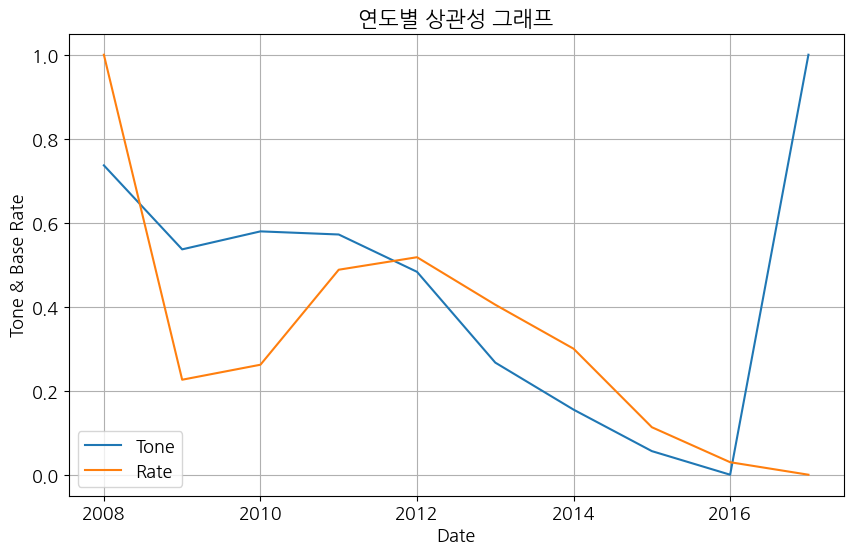

In [25]:
# x, y 넘파이 배열로 변환
x = np.array(grouped_df["year"])
y1 = np.array(grouped_df["tone_doc"]).reshape(-1, 1)
y2 = np.array(grouped_df["rate"]).reshape(-1, 1)

y1_scaled = scaler.fit_transform(y1)
y2_scaled = scaler.fit_transform(y2)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (10, 6))

plt.plot(x, y1_scaled, label = "Tone")
plt.plot(x, y2_scaled, label = "Rate")

plt.xlabel("Date")
plt.ylabel("Tone & Base Rate")
plt.title("연도별 상관성 그래프")
plt.legend()
plt.grid(True)
plt.show()